In [0]:
!nvidia-smi

Wed Apr  8 23:47:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !mkdir data
# %cd data
# !mkdir left right
# %cd ..

/content/data
/content


In [0]:
# !cp -a /content/drive/My\ Drive/Inria_data/Pose/left/. ./data/left/
# !cp -a /content/drive/My\ Drive/Inria_data/Person/left/. ./data/left/
# !cp -a /content/drive/My\ Drive/Inria_data/Video/left/. ./data/left/
# !cp -a /content/drive/My\ Drive/Inria_data/Segmentation/left/. ./data/left/
# !cp -a /content/drive/My\ Drive/Inria_data/Negative/left/. ./data/left/

# !cp -a /content/drive/My\ Drive/Inria_data/Pose/right/. ./data/right/
# !cp -a /content/drive/My\ Drive/Inria_data/Person/right/. ./data/right/
# !cp -a /content/drive/My\ Drive/Inria_data/Video/right/. ./data/right/
# !cp -a /content/drive/My\ Drive/Inria_data/Segmentation/right/. ./data/right/
# !cp -a /content/drive/My\ Drive/Inria_data/Negative/right/. ./data/right/

In [0]:
!cp /content/drive/My\ Drive/data.zip ./
!unzip -q data.zip

In [0]:
import os
import numpy as np
from PIL import Image
import glob
import tqdm

import torch
import torchvision   
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.utils.data as data

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=(160, 384)),
        # transforms.RandomCrop((160, 384)),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(160, 384)),
        # transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize([0.3651, 0.2656, 0.2544], [0.1847, 0.1425, 0.1418])
    ]),
}

In [0]:
folder_path = "./data/"

left_files = glob.glob(os.path.join(folder_path,'left','*.jpg'))
right_files = glob.glob(os.path.join(folder_path,'right','*.jpg'))

idxs = np.arange(len(left_files))
np.random.shuffle(idxs)

train_idxs = idxs[:int(0.8*len(left_files))]
val_idxs = idxs[int(0.8*len(left_files)):]

train_lfiles = [left_files[idx] for idx in train_idxs]
train_rfiles = [right_files[idx] for idx in train_idxs]

val_lfiles = [left_files[idx] for idx in val_idxs]
val_rfiles = [right_files[idx] for idx in val_idxs]

In [0]:
class Inria(data.Dataset):
    def __init__(self, lfiles, rfiles, transform=None):
        super(Inria, self).__init__()
        self.left_files = lfiles
        self.right_files = rfiles

        self.transform = transform
        # self.mask_files = []
        # for img_path in img_files:
        #      self.mask_files.append(os.path.join(folder_path,'mask',os.path.basename(img_path)) 

    def __getitem__(self, index):

            left_img_path = self.left_files[index]
            right_img_path = self.right_files[index]

            # left = Image.open(left_img_path)
            # right = Image.open(left_img_path)

            left = cv2.resize(cv2.imread(left_img_path), (384, 160)).astype(np.float32)
            right = cv2.resize(cv2.imread(right_img_path), (384, 160)).astype(np.float32)

            left = (torch.from_numpy(left).permute(2, 0, 1))
            right = (torch.from_numpy(right).permute(2, 0, 1))
            # print(left.shape)

            # input_img = input_img

            # input_img = np.rollaxis(input_img, 2, 0)
            # input_img = np.reshape(input_img, (1, 3, 160, 384))  
            # # input_img = input_img.transpose((1, 3, 160, 384))
            # input_img = torch.FloatTensor(input_img)

            # if self.transform:
            #   left = self.transform(left)
            #   right = self.transform(right)

            # print(left.shape)

            # left = torchvision.transforms.ToTensor()(Image.open(left_img_path))
            # right = torchvision.transforms.ToTensor()(Image.open(right_img_path))

            # img = torchvision.transforms.ToTensor()(img)Œ

            return left, right

    def __len__(self):
        return len(self.left_files)

In [0]:
train_dataset = Inria(train_lfiles, train_rfiles, data_transforms['train'])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)

val_dataset = Inria(val_lfiles, val_rfiles, data_transforms['test'])
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=8)

In [0]:
for x, y in train_dataloader:
  print(x.shape, y.shape)
  break

torch.Size([32, 3, 160, 384]) torch.Size([32, 3, 160, 384])


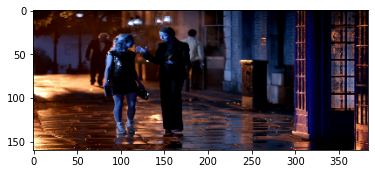

-15382.0


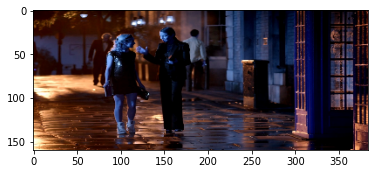

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

img = np.transpose(train_dataset[32][0].numpy().astype(int), (1, 2, 0)) 
plt.imshow(img)
plt.show()

print(np.sum(train_dataset[32][0].numpy() - train_dataset[32][1].numpy()))
img = np.transpose(train_dataset[32][1].numpy().astype(int), (1, 2, 0)) 
plt.imshow(img)
plt.show()

In [0]:
class Deep3D(nn.Module):
    def __init__(self):
        super(Deep3D, self).__init__()
        
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.relu1_1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu2_1 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.relu3_2 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.relu4_2 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.relu5_2 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc6 = nn.Linear(30720, 512)  
        self.relu6 = nn.ReLU()
        self.drop6 = nn.Dropout(p=0.5)

        self.fc7 = nn.Linear(512, 512)  
        self.relu7 = nn.ReLU()
        self.drop7 = nn.Dropout(p=0.5)

        self.fc8 = nn.Linear(512, 33*12*5)
        # rehape in forward to get pred5

        self.bn_pool4 = nn.BatchNorm2d(512)
        self.pred4 = nn.Conv2d(in_channels=512 ,out_channels=33, kernel_size=3 ,padding=1)
        self.bn_pool3 = nn.BatchNorm2d(256)
        self.pred3 = nn.Conv2d(in_channels=256 ,out_channels=33, kernel_size=3 ,padding=1)
        self.bn_pool2 = nn.BatchNorm2d(128)
        self.pred2 = nn.Conv2d(in_channels=128 ,out_channels=33, kernel_size=3 ,padding=1)
        self.bn_pool1 = nn.BatchNorm2d(64)
        self.pred1 = nn.Conv2d(in_channels=64 ,out_channels=33, kernel_size=3 ,padding=1)
        
        workspace = 0
        scale = 1

        self.relu = nn.ReLU()

        self.deconv_pred1 = nn.ConvTranspose2d(in_channels=33, out_channels=33, kernel_size=1, padding=0, stride=1)
        scale *= 2

        self.deconv_pred2 = nn.ConvTranspose2d(in_channels=33, out_channels=33, kernel_size=2*scale, padding=scale//2, stride=scale)
        scale *= 2

        self.deconv_pred3 = nn.ConvTranspose2d(in_channels=33, out_channels=33, kernel_size=2*scale, padding=scale//2, stride=scale)
        scale *= 2

        self.deconv_pred4 = nn.ConvTranspose2d(in_channels=33, out_channels=33, kernel_size=2*scale, padding=scale//2, stride=scale)
        scale *= 2

        self.deconv_pred5 = nn.ConvTranspose2d(in_channels=33, out_channels=33, kernel_size=2*scale, padding=scale//2, stride=scale)
        self.relu1 =  nn.ReLU()
        scale = 2
        self.deconv_predup = nn.ConvTranspose2d(in_channels=33, out_channels=33, kernel_size=2*scale, padding=scale//2, stride=scale)
        self.relu2 = nn.ReLU()
        self.convolution0 = nn.Conv2d(in_channels=33 ,out_channels=33, kernel_size=3 ,padding=1)

        self.softmax = nn.Softmax()

        # self.linear_closs = nn.Linear(hidden_sizes[5], feat_dim, bias=False)

    def forward(self, x, evalMode=False):
        out = x
        
        out = self.relu1_1(self.conv1_1(out))
        pool1 = self.pool1(out)

        out = self.relu2_1(self.conv2_1(pool1))
        pool2 = self.pool2(out)

        out = self.relu3_1(self.conv3_1(pool2))
        out = self.relu3_2(self.conv3_2(out))
        pool3 = self.pool3(out)

        out = self.relu4_1(self.conv4_1(pool3))
        out = self.relu4_2(self.conv4_2(out))
        pool4 = self.pool4(out)

        out = self.relu5_1(self.conv5_1(pool4))
        out = self.relu5_2(self.conv5_2(out))
        pool5 = self.pool5(out)

        out = self.flatten(pool5)

        out = self.drop6(self.relu6(self.fc6(out)))
        out = self.drop7(self.relu7(self.fc7(out)))

        out = self.fc8(out)

        pred5 = torch.reshape(out, (out.shape[0], 33, 5, 12))

        pred4 = self.bn_pool4(pool4)
        pred4 = self.pred4(pred4)
        pred3 = self.bn_pool3(pool3)
        pred3 = self.pred3(pred3)
        pred2 = self.bn_pool2(pool2)
        pred2 = self.pred2(pred2)
        pred1 = self.bn_pool1(pool1)
        pred1 = self.pred1(pred1)

        pred1 = self.deconv_pred1(self.relu(pred1))
        pred2 = self.deconv_pred2(self.relu(pred2))
        pred3 = self.deconv_pred3(self.relu(pred3))
        pred4 = self.deconv_pred4(self.relu(pred4))
        pred5 = self.deconv_pred5(self.relu(pred5))

        pred = pred1 + pred2 + pred3 + pred4 + pred5
        pred = self.relu(pred)

        pred = self.convolution0(self.relu(self.deconv_predup(pred)))

        mask = self.softmax(pred)

        return mask

def selection_layer(masks, left_image, left_shift=16):

    p2d = (left_shift, left_shift, 0, 0)
    padded_img = F.pad(left_image, p2d, 'constant')

    depth = masks.shape[1]
    width = left_image.shape[3]
    layers = []
    # layers.append(torch.zeros(padded_img[:,:,:,:width].shape).to(device))
    for d in range(depth-1,-1,-1):
        layers.append(padded_img[:,:,:,d:d+width])
    layers = torch.stack(layers, axis=1)
    disparity_image =  layers * masks.unsqueeze(2)

    return torch.sum(disparity_image, axis=1)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

net = Deep3D()
net = net.to(device)

cuda


In [0]:
checkpoint = torch.load("/content/drive/My Drive/pre_trained_weights.pt")
net.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [0]:
def train(model, data_loader, val_loader, n_epochs, criterion):

    for epoch in range(n_epochs):
        model.train()
        avg_loss = 0.0
        num_correct = 0.0
        total = 0.0

        outer = tqdm.notebook.tqdm(total=len(data_loader), desc='training')

        for batch_num, (left_img, right_img) in enumerate(data_loader):
            outer.update(1)
            left_img, right_img = left_img.to(device), right_img.to(device)
            
            optimizer.zero_grad()

            outputs = model(left_img)
            outputs = selection_layer(outputs, left_img)

            loss = criterion(outputs, right_img)
            loss.backward()
            optimizer.step()
            
            avg_loss += loss.item()
            total += left_img.shape[0]

            if batch_num % 10 == 9:
                print('Epoch: {}\tBatch: {}\tAvg-Loss: {:.9f}'.format(epoch+1, batch_num+1, avg_loss/total))
                # avg_loss = 0.0    
            
            torch.cuda.empty_cache()
            del left_img
            del right_img
            del loss

        torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_label_state_dict': optimizer.state_dict(),
        }, '/content/drive/My Drive/11785/' + 'weight' + '_' + str(epoch) + '.pt')

        val(model, val_loader, criterion)

In [0]:
def val(model, data_loader, criterion):

      model.eval()

      avg_loss = 0.0
      num_correct = 0.0
      total = 0.0

      outer = tqdm.notebook.tqdm(total=len(data_loader), desc='validation')

      for batch_num, (left_img, right_img) in enumerate(data_loader):
          outer.update(1)
          left_img, right_img = left_img.to(device), right_img.to(device)
          
          outputs = model(left_img)
          outputs = selection_layer(outputs, left_img)

          loss = criterion(outputs, right_img)
          
          avg_loss += loss.item()
          total += left_img.shape[0]

      print('Avg-Val-Loss: {:.9f}'.format(avg_loss/total))
        

In [0]:
# criterion = nn.L1Loss()
# optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

# # for state in optimizer.state.values():
# #     for k, v in state.items():
# #         if isinstance(v, torch.Tensor):
# #             state[k] = v.cuda()

# for param_group in optimizer.param_groups:
#     param_group['lr'] = 3e-5

train(net, train_dataloader, val_dataloader, 3, criterion)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1	Batch: 10	Avg-Loss: 0.225146031
Epoch: 1	Batch: 20	Avg-Loss: 0.226313562
Epoch: 1	Batch: 30	Avg-Loss: 0.226060648
Epoch: 1	Batch: 40	Avg-Loss: 0.227986873
Epoch: 1	Batch: 50	Avg-Loss: 0.228705600
Epoch: 1	Batch: 60	Avg-Loss: 0.228616049
Epoch: 1	Batch: 70	Avg-Loss: 0.228465405
Epoch: 1	Batch: 80	Avg-Loss: 0.226684571


Avg-Val-Loss: 0.255154660


Epoch: 2	Batch: 10	Avg-Loss: 0.230127910
Epoch: 2	Batch: 20	Avg-Loss: 0.225670425
Epoch: 2	Batch: 30	Avg-Loss: 0.225049994
Epoch: 2	Batch: 40	Avg-Loss: 0.225514918
Epoch: 2	Batch: 50	Avg-Loss: 0.225213465
Epoch: 2	Batch: 60	Avg-Loss: 0.225026350
Epoch: 2	Batch: 70	Avg-Loss: 0.225325646
Epoch: 2	Batch: 80	Avg-Loss: 0.225341144


Avg-Val-Loss: 0.254178121


Epoch: 3	Batch: 10	Avg-Loss: 0.228637591
Epoch: 3	Batch: 20	Avg-Loss: 0.227467588
Epoch: 3	Batch: 30	Avg-Loss: 0.225642276
Epoch: 3	Batch: 40	Avg-Loss: 0.225558247
Epoch: 3	Batch: 50	Avg-Loss: 0.224337810
Epoch: 3	Batch: 60	Avg-Loss: 0.223579805
Epoch: 3	Batch: 70	Avg-Loss: 0.222779959
Epoch: 3	Batch: 80	Avg-Loss: 0.224086691


Avg-Val-Loss: 0.253129849


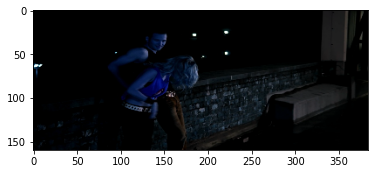

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

img = np.transpose(train_dataset[35][0].numpy().astype(np.uint8), (1, 2, 0)) 
plt.imshow(img)
plt.show()

In [0]:
import cv2
def test(model, img_path):
    model.eval()
    with torch.no_grad():
      shape = (384, 160)
      input_img = cv2.imread(img_path)
      input_img = cv2.resize(input_img, (384, 160))
      left = input_img

      plt.imshow(input_img)
      plt.show()

      input_img = input_img.astype(np.float32)
      input_img = np.rollaxis(input_img, 2, 0)
      input_img = np.reshape(input_img, (1, 3, 160, 384))  
      input_img = torch.FloatTensor(input_img)
      input_img = input_img.to(device)

      mask = net(input_img)

      plt.imshow(mask.detach().cpu().numpy()[0, 0])
      plt.show()

      plt.imshow(mask.detach().cpu().numpy()[0, 6])
      plt.show()

      plt.imshow(mask.detach().cpu().numpy()[0, 10])
      plt.show()

      plt.imshow(mask.detach().cpu().numpy()[0, 13])
      plt.show()

      plt.imshow(mask.detach().cpu().numpy()[0, 23])
      plt.show()

      plt.imshow(mask.detach().cpu().numpy()[0, 30])
      plt.show()

      right_image = selection_layer(mask, input_img).detach().cpu().numpy()
      right_image = np.clip(right_image.squeeze().transpose((1,2,0)), 0, 255).astype(np.uint8)
      right = right_image

      plt.imshow(right_image)
      plt.show()
      right_image = Image.fromarray(cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB))

      print(input_img.shape)
      left_image = np.clip(input_img.cpu().numpy().squeeze().transpose((1,2,0)), 0, 255).astype(np.uint8)
      left_image = Image.fromarray(cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB))

      right_image.save('right.jpg')
      left_image.save('left.jpg')
      return left_image, right_image

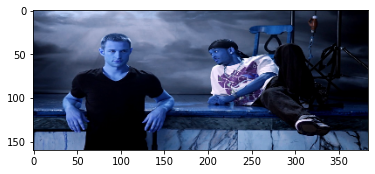

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


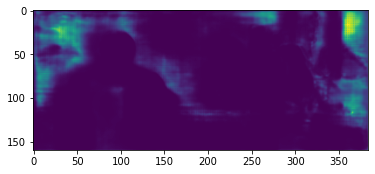

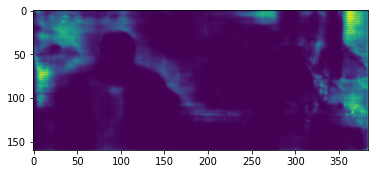

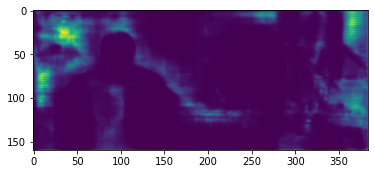

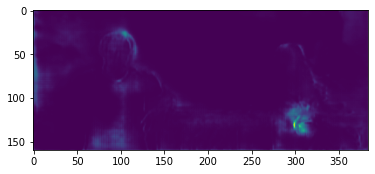

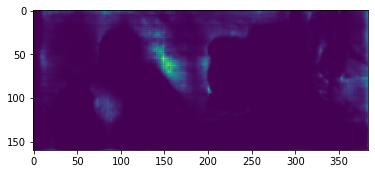

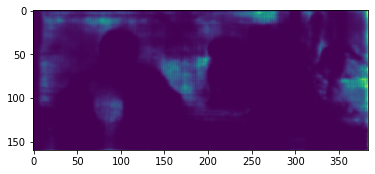

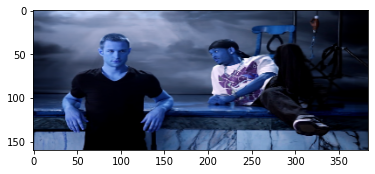

torch.Size([1, 3, 160, 384])


(<PIL.Image.Image image mode=RGB size=384x160 at 0x7FDC4F048AC8>,
 <PIL.Image.Image image mode=RGB size=384x160 at 0x7FDC4FD684E0>)

In [0]:
test(net, './data/left/00001273.jpg')